In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

In [3]:
data = pd.read_csv("data.csv")

In [4]:
data.head()

,Unnamed: 0,temp,humidity
0,0,23.90,57.96
1,1,26.22,57.42
2,2,25.97,52.15
3,3,26.16,55.86
4,4,25.16,56.43


In [5]:
data_set = data.values[:,1:3]

In [6]:
data_set.shape

(10000, 2)

In [7]:
data_set

array([[23.9 , 57.96],
       [26.22, 57.42],
       [25.97, 52.15],
       ...,
       [12.33, 36.59],
       [10.99, 37.58],
       [12.87, 36.89]])

In [8]:
humidity = torch.empty(len(data_set[:,1])-3,4)
for i in range(len(data_set[:,0])-3):
    humidity[i,0] = torch.tensor(data_set[i,1])
    humidity[i,1] = torch.tensor(data_set[i+1,1])
    humidity[i,2] = torch.tensor(data_set[i+2,1])
    humidity[i,3] = torch.tensor(data_set[i+3,1])

In [9]:
humidity_x = humidity[:,0:3]
humidity_y = humidity[:,-1]

In [10]:
humidity_x_train, humidity_x_test, humidity_y_train,humidity_y_test = train_test_split(humidity_x, humidity_y,  
                                                                        test_size = 0.1, shuffle = False)

In [11]:
print(humidity_x_train.shape)
print(humidity_y_train.shape)
print(humidity_x_test.shape)
print(humidity_y_test.shape)

torch.Size([8997, 3])
torch.Size([8997])
torch.Size([1000, 3])
torch.Size([1000])


In [13]:
print(humidity_x_train[0:5,:])
print(humidity_y_train[0:5])
print(humidity_x_test[2,:])
print(humidity_y_test[2])
print(type(humidity_y_test[2]))

tensor([[57.9600, 57.4200, 52.1500],
        [57.4200, 52.1500, 55.8600],
        [52.1500, 55.8600, 56.4300],
        [55.8600, 56.4300, 57.0600],
        [56.4300, 57.0600, 53.8000]])
tensor([55.8600, 56.4300, 57.0600, 53.8000, 57.6700])
tensor([85.5500, 85.2200, 90.0100])
tensor(87.2600)
<class 'torch.Tensor'>


In [14]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(3, 32)
        self.fc2 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [15]:
# 定义训练函数
def train(model, device, train_loader, optimizer, criterion):
    model.train()
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

# 定义测试函数
def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
    test_loss /= len(test_loader.dataset)
    return test_loss

In [16]:
if __name__ == '__main__':
  
    x_train = humidity_x_train
    y_train = humidity_y_train
    train_data = TensorDataset(x_train, y_train)
    train_loader = DataLoader(train_data, batch_size=32, shuffle=False)
    
    x_test = humidity_x_test
    y_test = humidity_y_test
    test_data = TensorDataset(x_test, y_test)
    test_loader = DataLoader(test_data, batch_size=32, shuffle=False)
    
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = DNN().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.MSELoss()
    
   
    epochs = 50
    best_loss = 1000
    for epoch in range(epochs):
        train(model, device, train_loader, optimizer, criterion)
        test_loss = test(model, device, test_loader, criterion)
        print('Epoch {}, Test Loss: {:.4f}'.format(epoch+1, test_loss))
        if best_loss > test_loss:
            best_loss = test_loss
            torch.save(model,"DNN_humidity.pt")
            print('best model saved')



/Users/jiaxingzhang/env/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/jiaxingzhang/env/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/jiaxingzhang/env/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same 

Epoch 1, Test Loss: 0.4585
best model saved
Epoch 2, Test Loss: 0.5569
Epoch 3, Test Loss: 0.6279
Epoch 4, Test Loss: 1.7498
Epoch 5, Test Loss: 1.0785
Epoch 6, Test Loss: 0.8277
Epoch 7, Test Loss: 0.8143
Epoch 8, Test Loss: 1.6124
Epoch 9, Test Loss: 1.2913
Epoch 10, Test Loss: 0.9936
Epoch 11, Test Loss: 1.1778
Epoch 12, Test Loss: 0.6892
Epoch 13, Test Loss: 1.1676
Epoch 14, Test Loss: 0.7137
Epoch 15, Test Loss: 1.8425
Epoch 16, Test Loss: 1.1575
Epoch 17, Test Loss: 1.1797
Epoch 18, Test Loss: 1.2512
Epoch 19, Test Loss: 1.2610
Epoch 20, Test Loss: 0.7326
Epoch 21, Test Loss: 0.8086
Epoch 22, Test Loss: 0.9465
Epoch 23, Test Loss: 0.6181
Epoch 24, Test Loss: 0.7171
Epoch 25, Test Loss: 1.5952
Epoch 26, Test Loss: 0.8645
Epoch 27, Test Loss: 1.4656
Epoch 28, Test Loss: 1.6599
Epoch 29, Test Loss: 0.7084
Epoch 30, Test Loss: 0.9232
Epoch 31, Test Loss: 1.4098
Epoch 32, Test Loss: 1.5724
Epoch 33, Test Loss: 1.2537
Epoch 34, Test Loss: 1.3672
Epoch 35, Test Loss: 2.1297
Epoch 36, Te

In [17]:
x = np.arange(0,100)
test = humidity_x_test[0:100,:]
test.shape

torch.Size([100, 3])

In [18]:
result = np.zeros([100])
predictor = torch.load("DNN_humidity.pt")
for i in range(len(test)):
    result[i] = predictor(test[i])

In [19]:
type(result)

numpy.ndarray

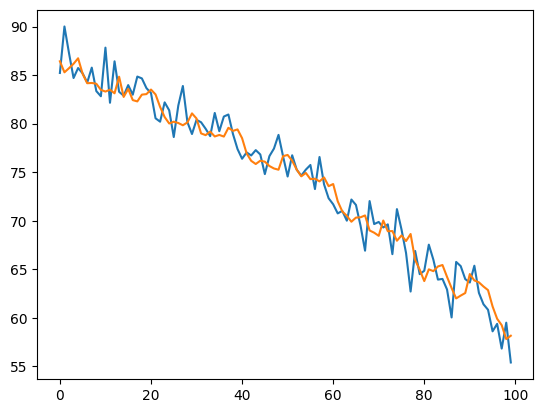

In [21]:
plt.plot(x,humidity_y_test[0:100])
plt.plot(x,result)

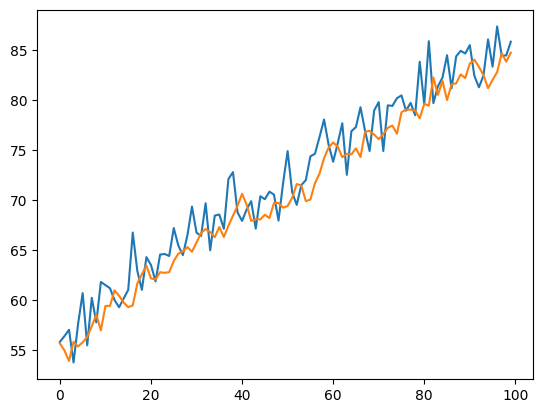

In [22]:
train = humidity_x_train[0:100,:]
result_train = np.zeros([100])
for i in range(len(train)):
    result_train[i] = predictor(train[i])
plt.plot(x,humidity_y_train[0:100])
plt.plot(x,result_train)

In [23]:
difference = humidity_y_test[0:100] - result
print(difference[0:10])

tensor([-1.2025,  4.7221,  1.5489, -1.4662, -1.0033,  0.0501,  0.0765,  1.5798,
        -0.7587, -0.6589], dtype=torch.float64)
